In [1]:
import os 
os.chdir('../../')
print("Current working directory is now: ", os.getcwd())

import numpy as np 
import pandas as pd 

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt 

from utils.load_settings import load_settings
from utils.fairness_functions import compute_calibration_discrete_score, parse_calibration_matrix
from utils.plot_fairness import plot_calibration_for_score_on_problem


%matplotlib inline
# load parameters
settings = load_settings()

Current working directory is now:  C:\Users\Caroline Wang\OneDrive\Duke\Criminal Recidivism\psa-analysis


Read in data, preprocess it

In [2]:
kentucky_arnold = pd.read_csv("kentucky/data/processed/kentucky_data.csv")

for decoder_name, decoder_dict in settings['decoders'].items():
    kentucky_arnold = kentucky_arnold.replace({decoder_name: decoder_dict})

kentucky_arnold.rename(columns=settings['decoders']['label'], inplace=True)
kentucky_arnold.rename(columns=settings['decoders']['arnold_name'], inplace=True)

In [3]:
# compute scaled arnold scores 
for score in ['arnold_nca' , 'arnold_nvca', 'arnold_fta']:
    kentucky_arnold[score] = kentucky_arnold[score + "_raw"]
    kentucky_arnold = kentucky_arnold.replace({score: settings[score + '_scaler'] })
    if score != 'arnold_nvca':
        kentucky_arnold[score] = kentucky_arnold[score].astype(int)

In [4]:
kentucky_arnold = kentucky_arnold[['person_id', 'screening_date', 
                                        'arnold_nca_raw', 'arnold_nca', 
                                        'arnold_nvca_raw', 'arnold_nvca', 
                                        'sex', 'race'] 
                                       + settings["labels"]]

# wide to long on sensitive attrs
kentucky_long = (pd.melt(kentucky_arnold, id_vars =['person_id', 'screening_date'], value_vars=['sex', 'race'])
                         .rename({'variable': 'Attribute',
                                  'value': 'Attribute Value'},
                                   axis=1))
kentucky_long = kentucky_long.merge(kentucky_arnold.drop(columns=['sex', 'race']),
                                                    on = ['person_id', 'screening_date'],
                                                    how = 'left')
kentucky_long.head()

,person_id,screening_date,Attribute,Attribute Value,arnold_nca_raw,arnold_nca,arnold_nvca_raw,arnold_nvca,general_two_year,general_six_month,drug_two_year,property_two_year,misdemeanor_two_year,felony_two_year,violent_two_year,drug_six_month,property_six_month,misdemeanor_six_month,felony_six_month,violent_six_month
0,5,2015-06-28,sex,male,5,4,4,Yes,0,0,0,0,0,0,0,0,0,0,0,0
1,8,2016-05-02,sex,male,10,6,3,No,1,1,0,0,1,1,0,0,0,0,1,0
2,12,2015-07-22,sex,male,2,2,1,No,0,0,0,0,0,0,0,0,0,0,0,0
3,23,2015-03-29,sex,male,5,4,2,No,0,0,0,0,0,0,0,0,0,0,0,0
4,27,2016-04-27,sex,male,6,4,3,No,1,1,1,0,1,0,1,1,0,1,0,0


## Calibration of Arnold PSA

First type of calibration: score of model should be reflective of true probability of recid

$P(Y = 1 | Score = score) = score$

Second type of calibration: calibration across groups should be the same 

$P(Y=1|S=s,G=g_1)=P(Y=1|S=s,G=g_2)$

Idea: plot overall calibration curve in bold black, and plot calibration curves for each group (race, sex) in different colors 

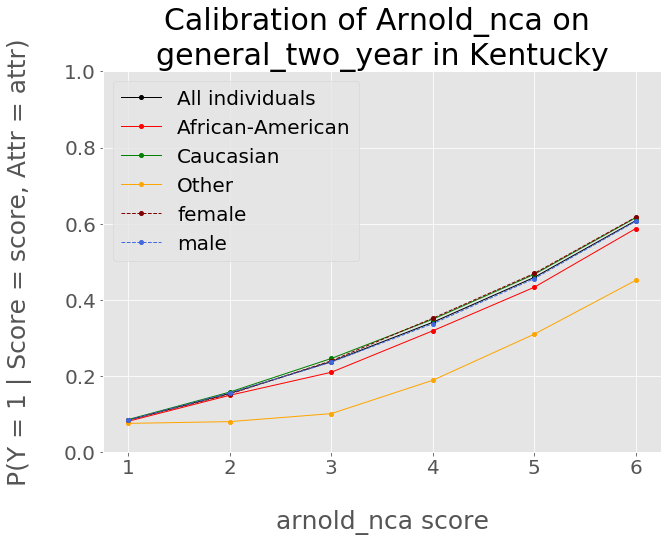

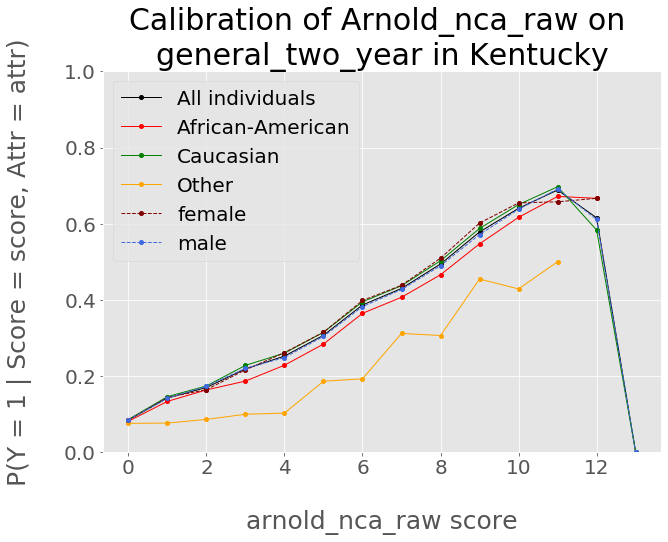

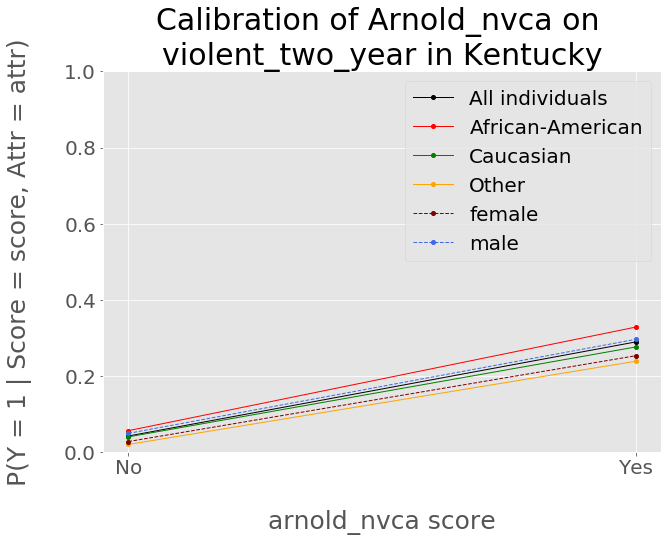

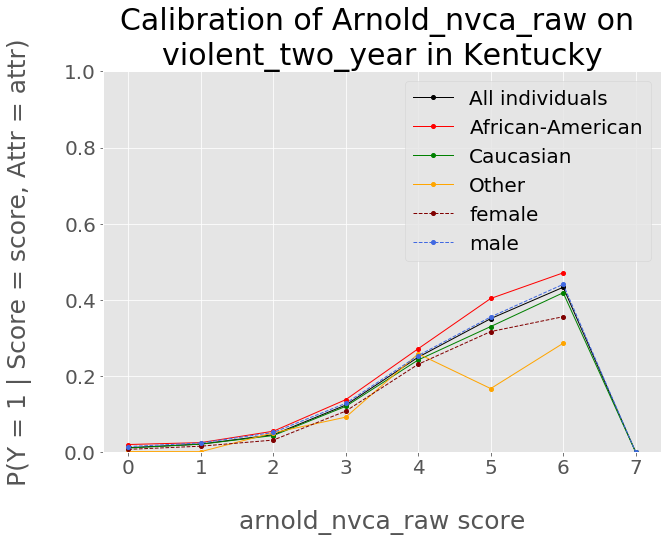

In [5]:
# calibration of PSA
scores_problem_dict = {'arnold_nca': ['general_two_year',
                                      'kentucky/logs/fairness_results/calibration_visualizations/arnold/arnold_nca_calib.pdf'],
                       'arnold_nca_raw': ['general_two_year', 
                                          'kentucky/logs/fairness_results/calibration_visualizations/arnold/arnold_nca_raw_calib.pdf'],
                       'arnold_nvca': ['violent_two_year', 
                                       'kentucky/logs/fairness_results/calibration_visualizations/arnold/arnold_ncva_calib.pdf'], 
                       'arnold_nvca_raw': ['violent_two_year', 
                                           'kentucky/logs/fairness_results/calibration_visualizations/arnold/arnold_ncva_raw_calib.pdf']
                      }

for score_name, (problem_name, save_path) in scores_problem_dict.items():
    calib, calib_grps = compute_calibration_discrete_score(long_df=kentucky_long, 
                                                            problem_name=problem_name, 
                                                            score_name=score_name)
#     print(calib_grps.columns)
    plot_calibration_for_score_on_problem(calib=calib,
                                          calib_grps=calib_grps,
                                           problem_name=problem_name,
                                           score_name=score_name,
                                           region="Kentucky",
                                           save_path=save_path)

## Calibration of RiskSLIM, EBM, L1 Logistic Regression 

Calibration is evaluated by averaging the calibration values from the each subfold of the fold of the nested CV procedure correspondign to the best hyperparameter set. 

In [6]:
# read in calibration data for all problems 
calibration_data = {}
for time_period in [
                    "six_month", 
                    "two_year"
]:
    
    for problem in ['drug', 'felony', 'general', 'misdemeanor', 'property', 'violent']:
        problem_path = "kentucky/calibration_matrix/" + time_period + "/" + problem
        dircontents = os.listdir()
        onlyfiles = [f for f in os.listdir(problem_path) if os.path.isfile(os.path.join(problem_path, f))]
        
        for filename in onlyfiles:
            model_name = filename.split("_")[0]
            if model_name in ['ebm', 'riskslim', 'stumps']:
                calibration_data["-".join((problem, time_period, model_name))] = pd.read_csv(problem_path + "/" + filename)

calibration_data.keys()


dict_keys(['drug-six_month-ebm', 'drug-six_month-riskslim', 'drug-six_month-stumps', 'felony-six_month-ebm', 'felony-six_month-riskslim', 'felony-six_month-stumps', 'general-six_month-ebm', 'general-six_month-riskslim', 'general-six_month-stumps', 'misdemeanor-six_month-ebm', 'misdemeanor-six_month-riskslim', 'misdemeanor-six_month-stumps', 'property-six_month-ebm', 'property-six_month-riskslim', 'property-six_month-stumps', 'violent-six_month-ebm', 'violent-six_month-riskslim', 'violent-six_month-stumps', 'drug-two_year-ebm', 'drug-two_year-riskslim', 'drug-two_year-stumps', 'felony-two_year-ebm', 'felony-two_year-riskslim', 'felony-two_year-stumps', 'general-two_year-ebm', 'general-two_year-riskslim', 'general-two_year-stumps', 'misdemeanor-two_year-ebm', 'misdemeanor-two_year-riskslim', 'misdemeanor-two_year-stumps', 'property-two_year-ebm', 'property-two_year-riskslim', 'property-two_year-stumps', 'violent-two_year-ebm', 'violent-two_year-riskslim', 'violent-two_year-stumps'])

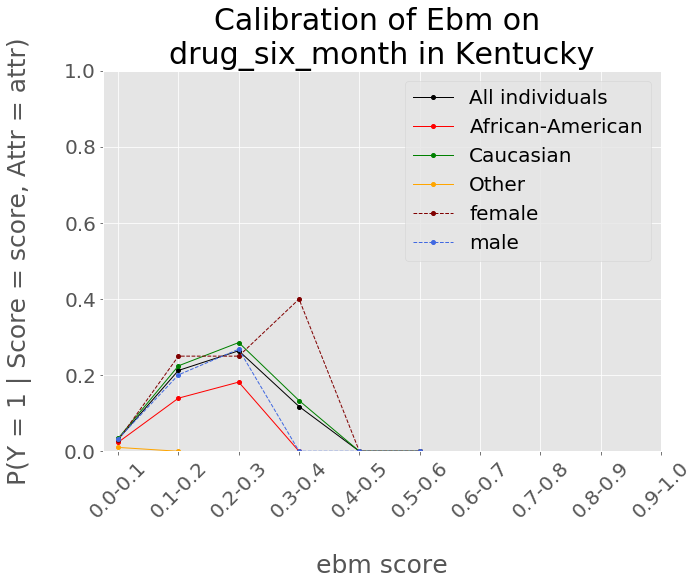

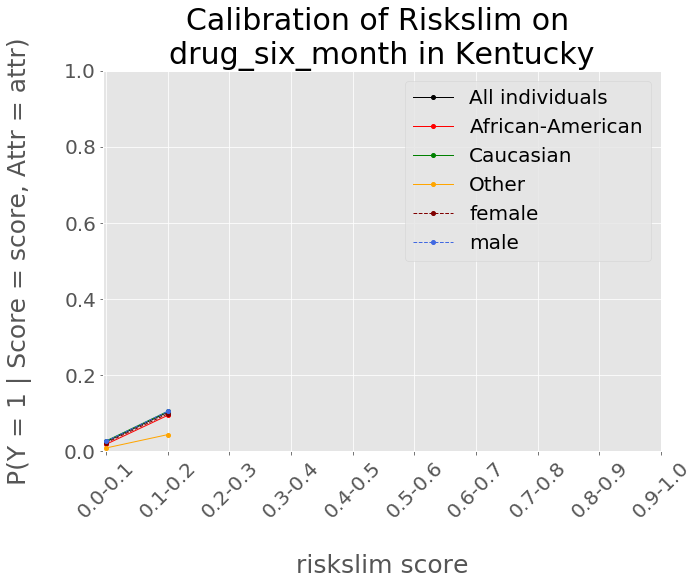

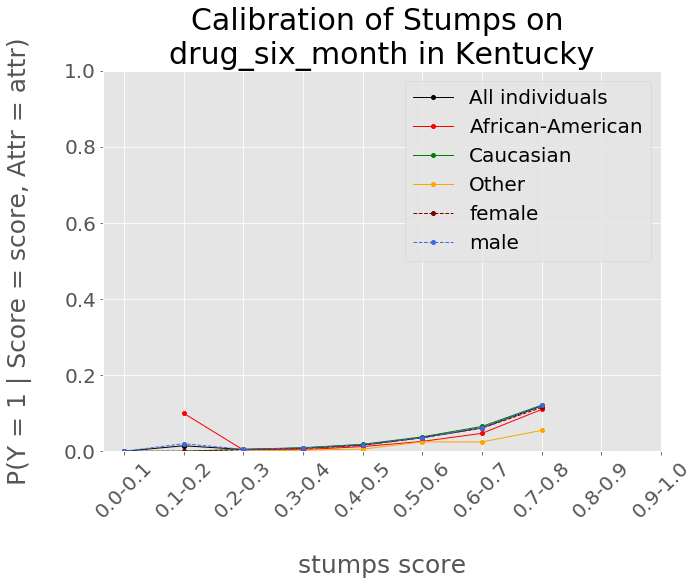

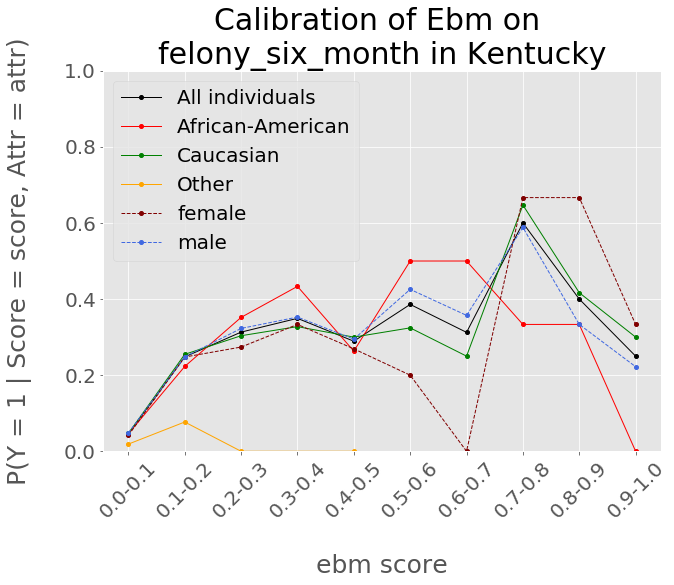

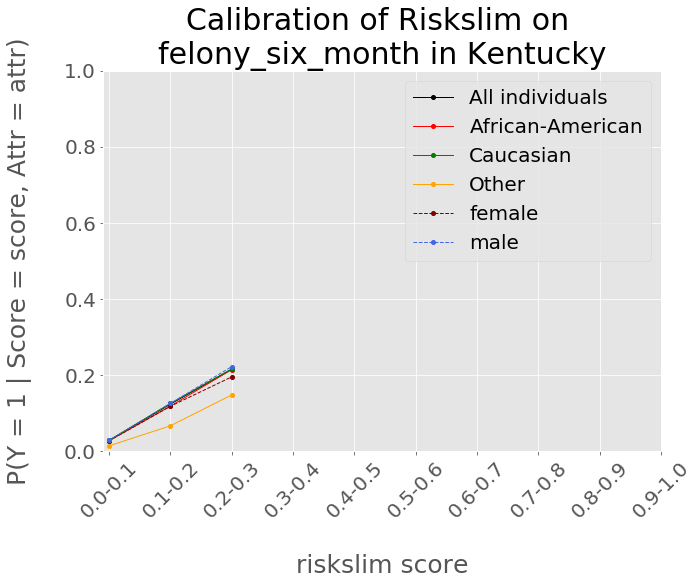

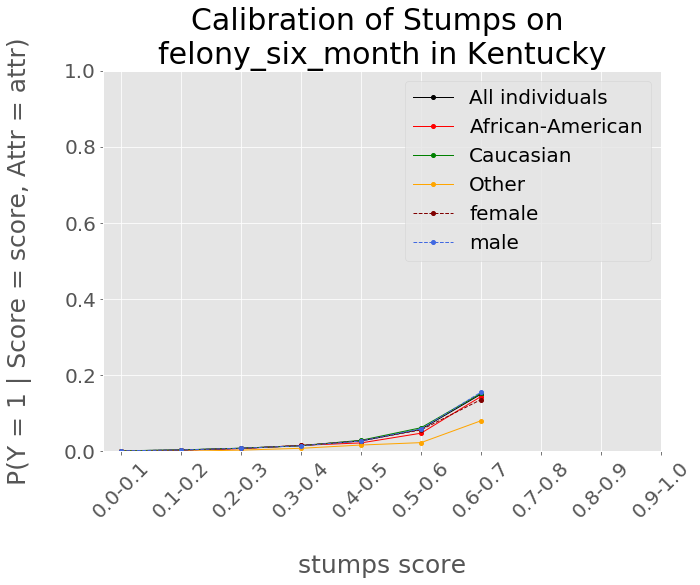

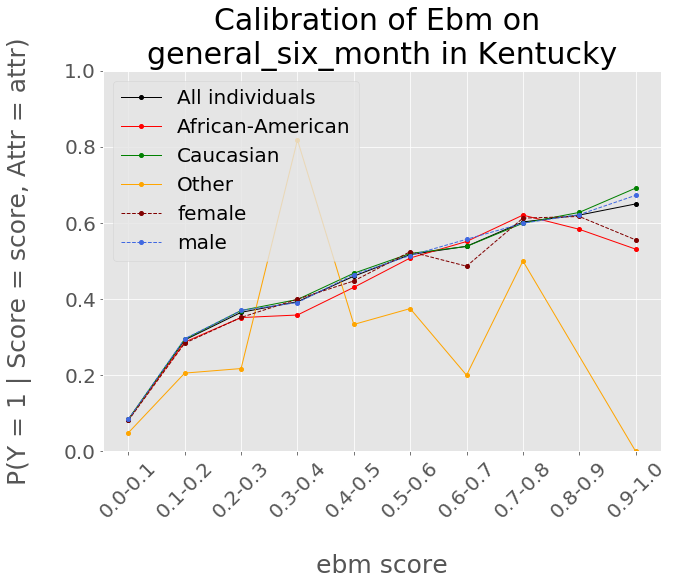

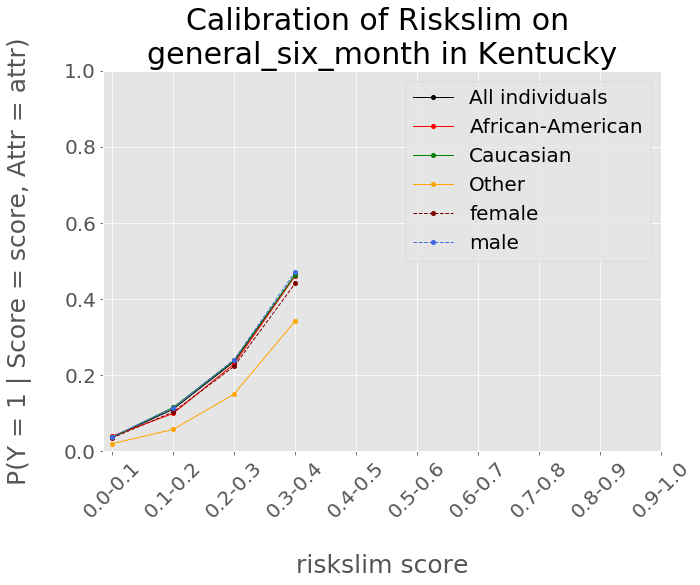

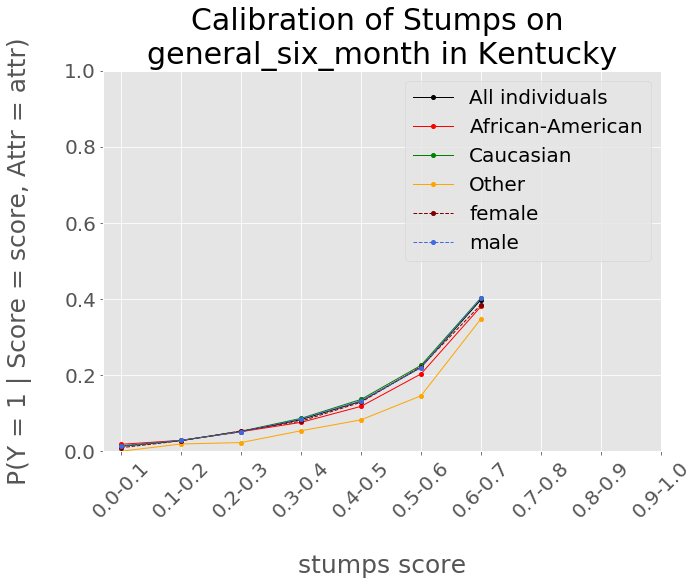

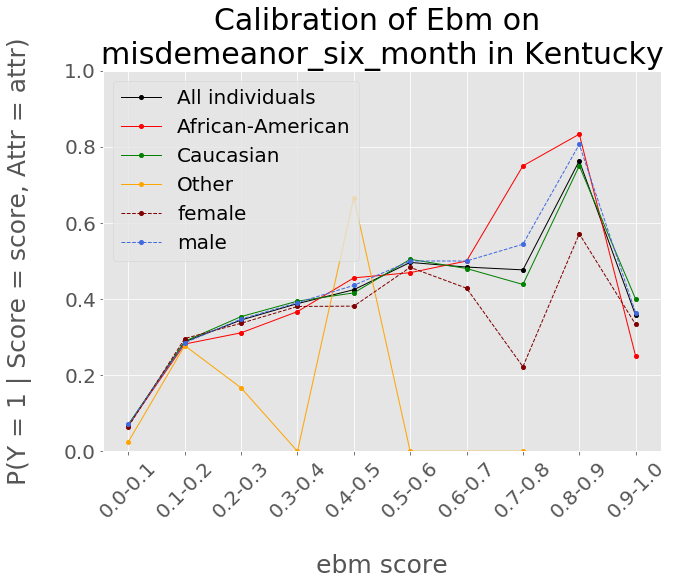

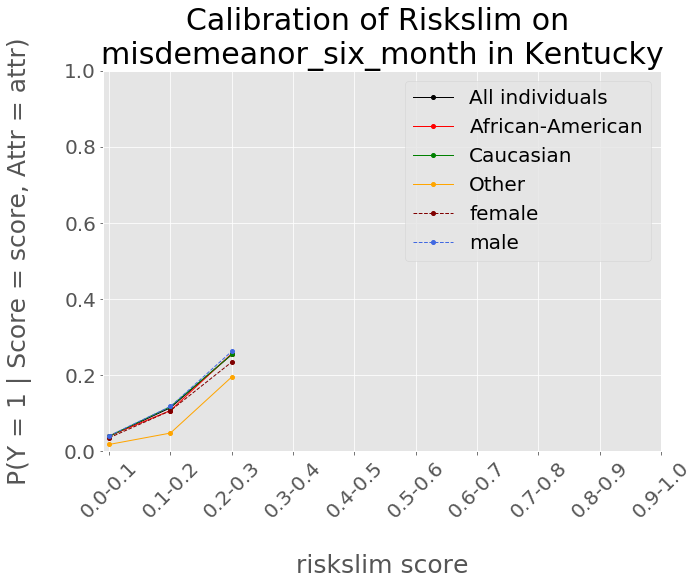

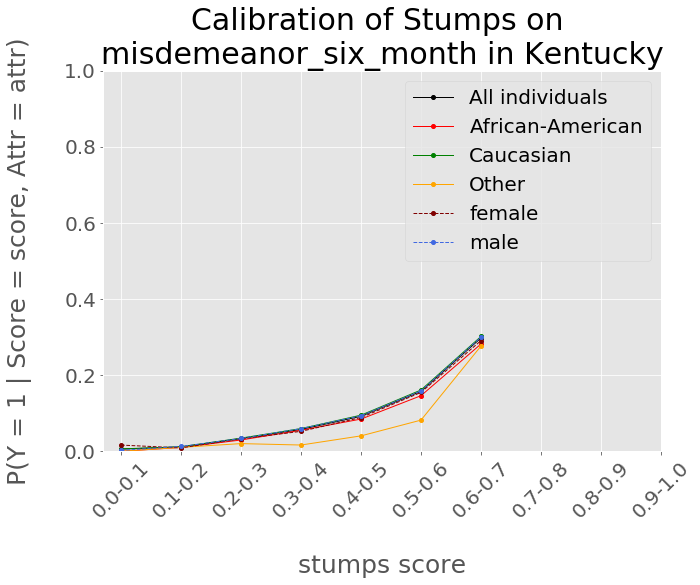

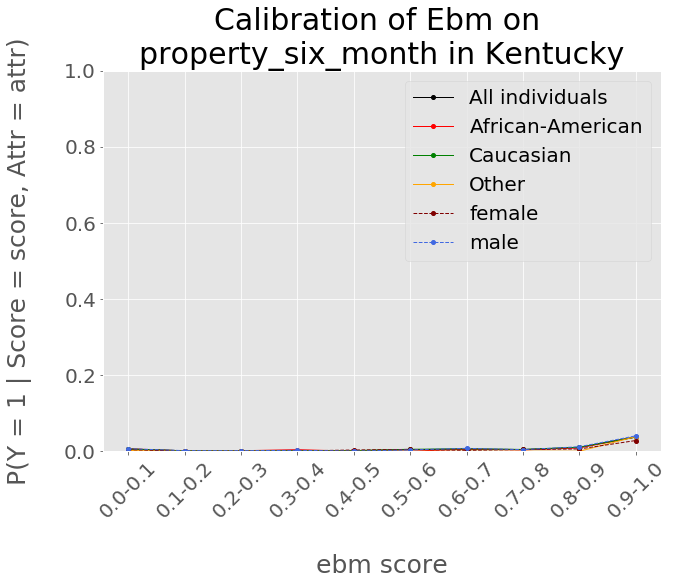

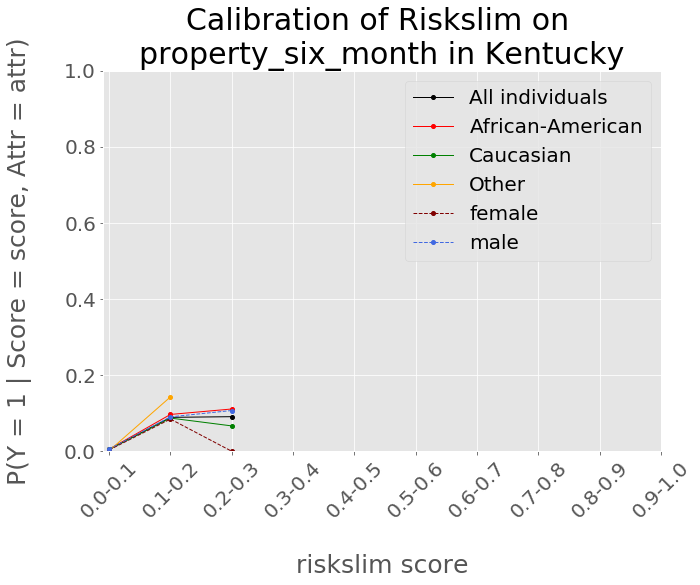

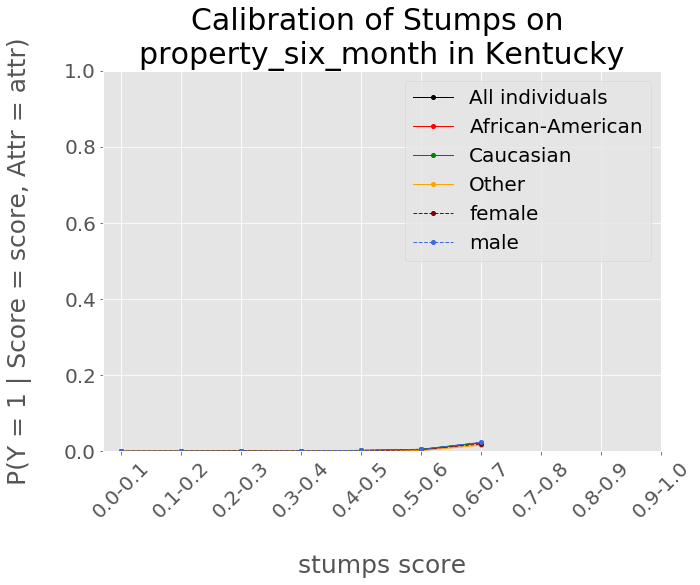

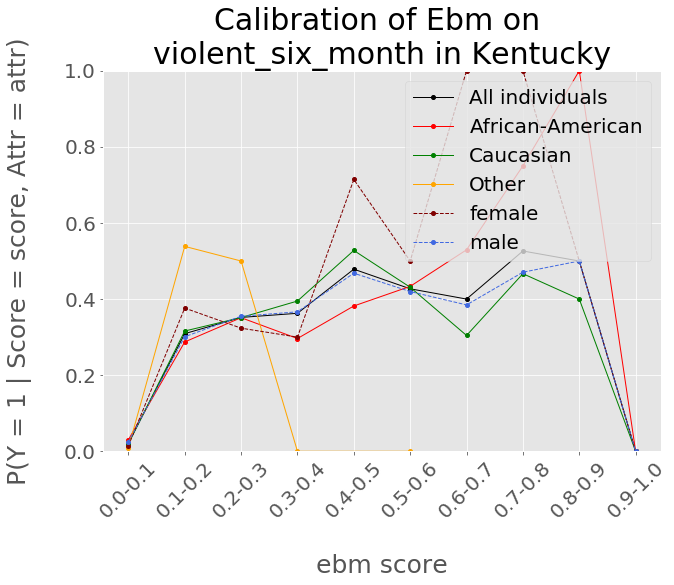

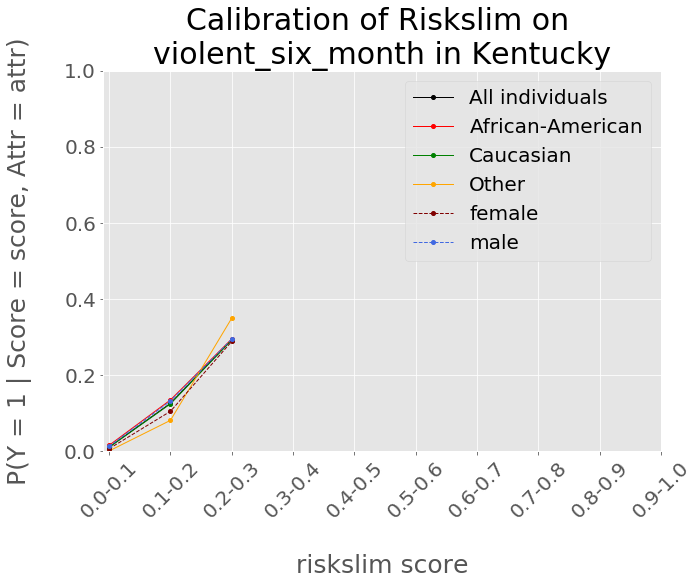

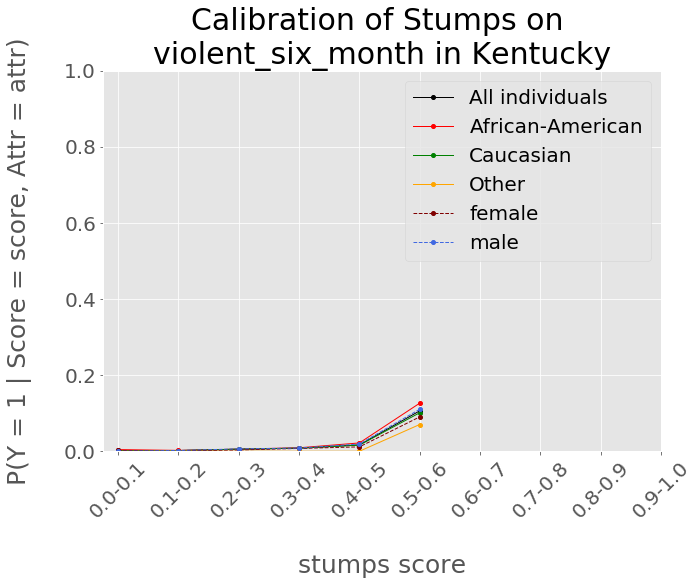

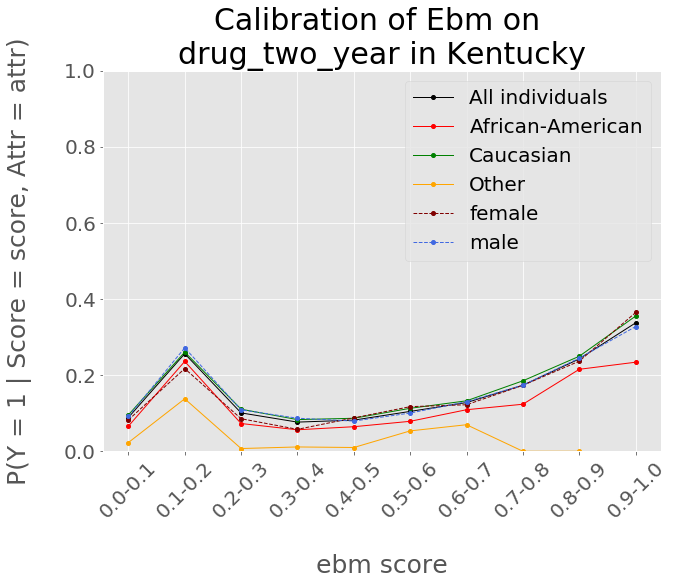

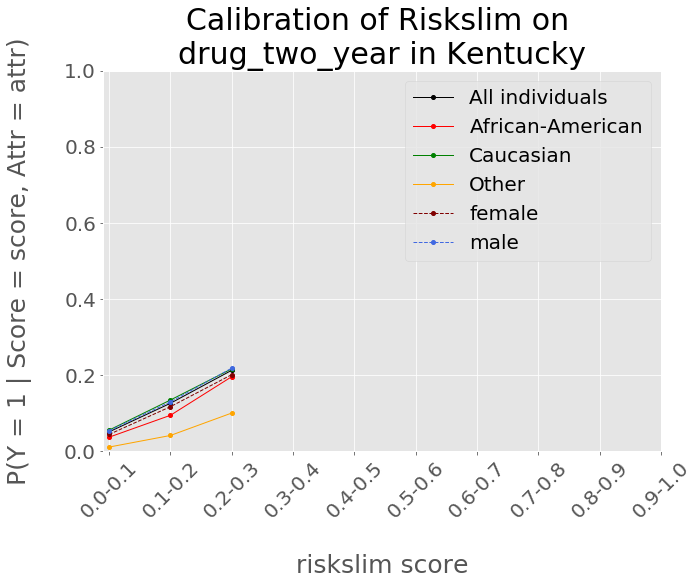

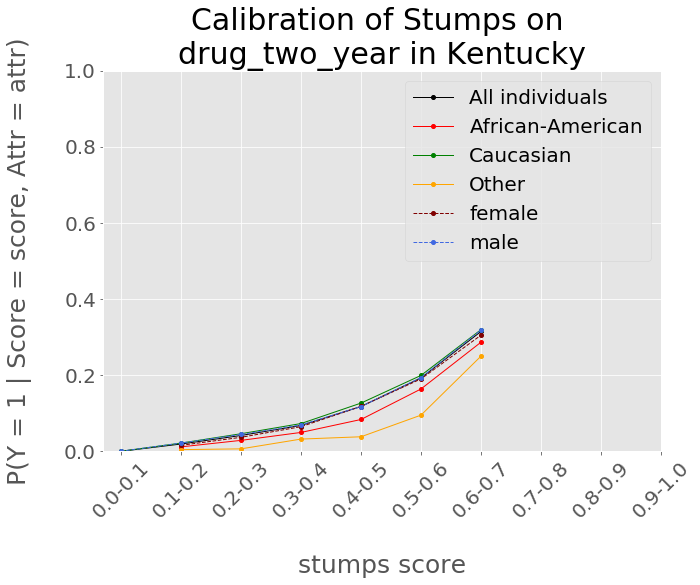

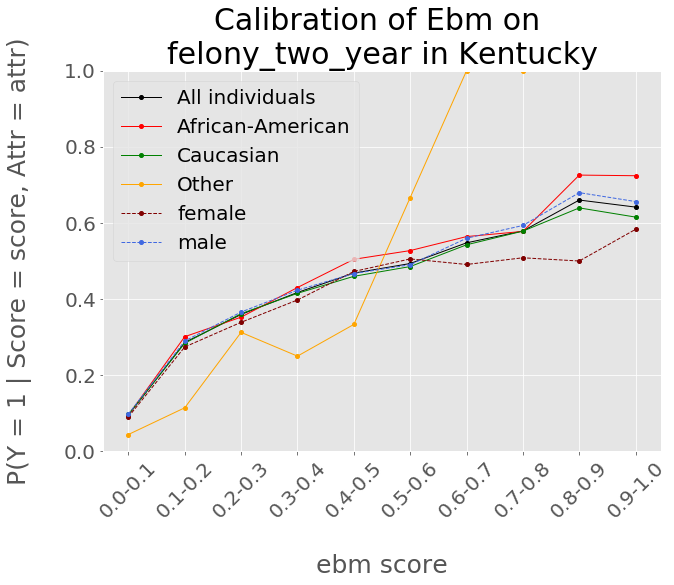

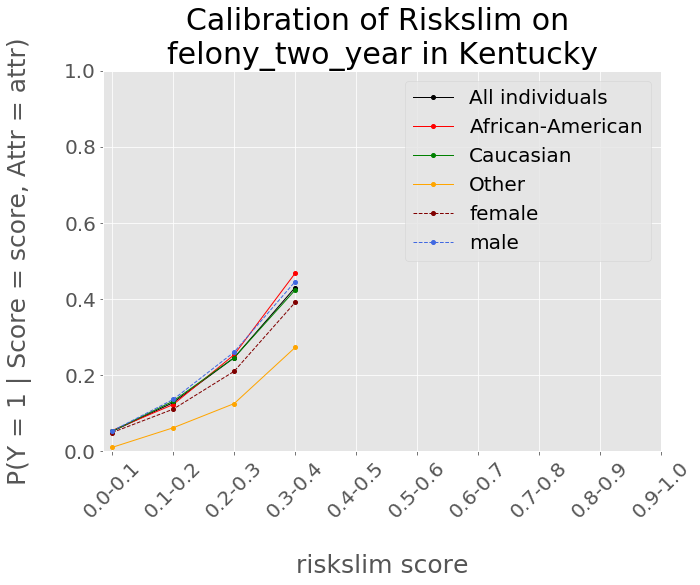

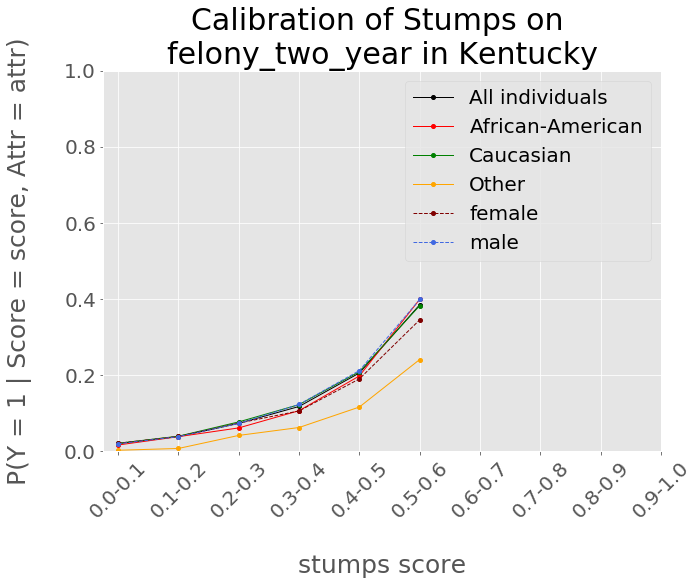

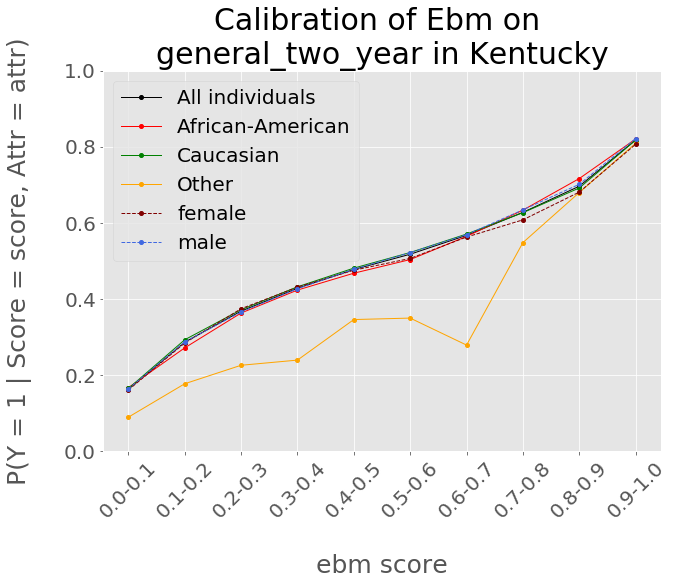

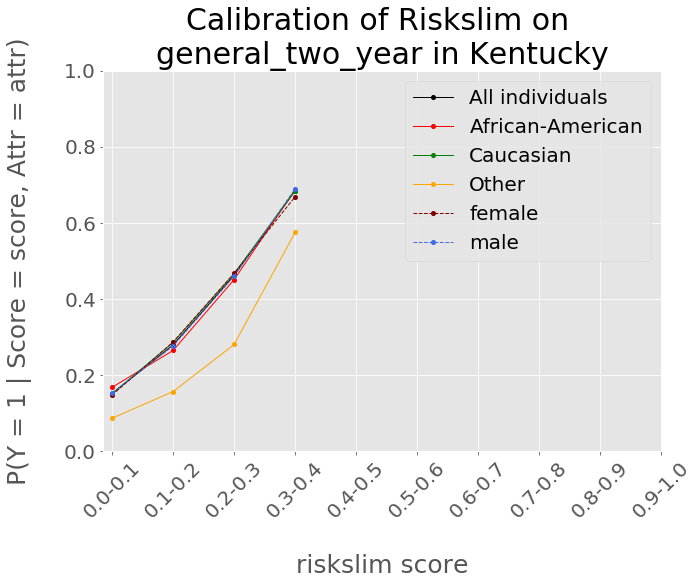

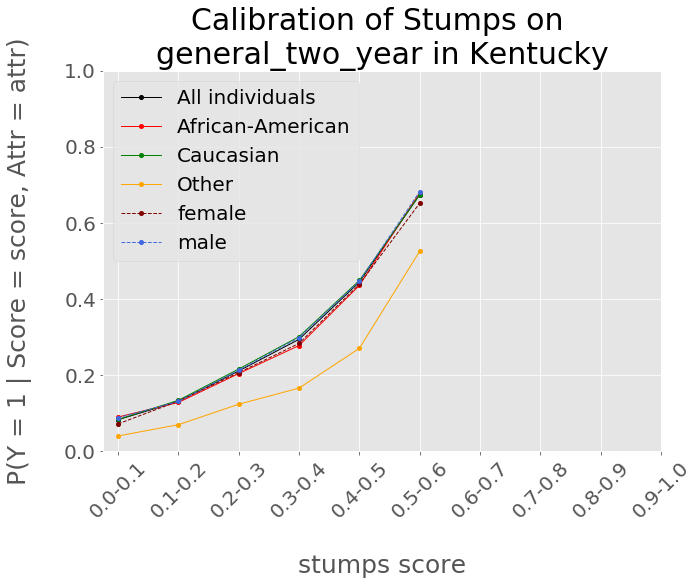

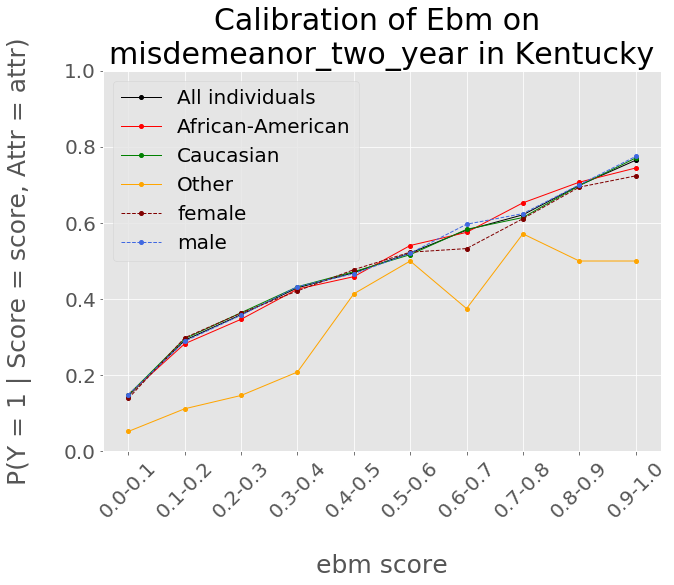

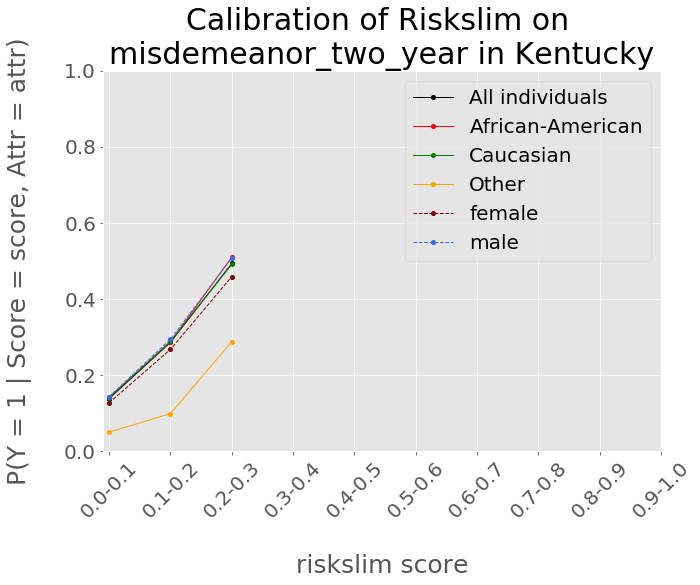

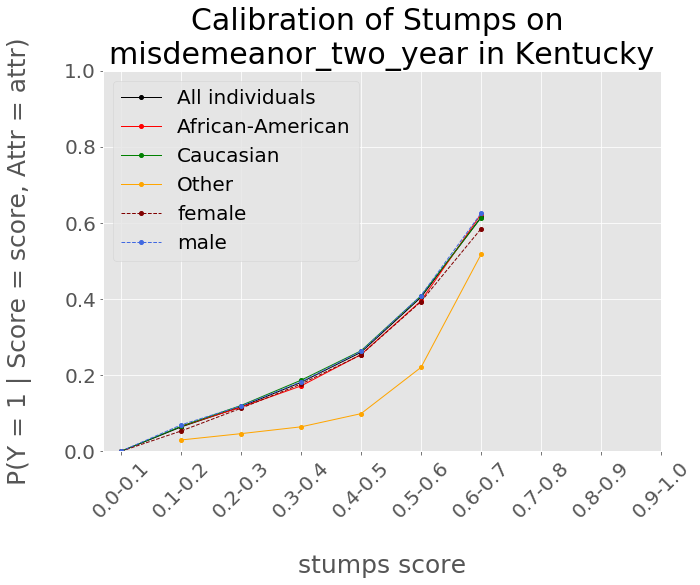

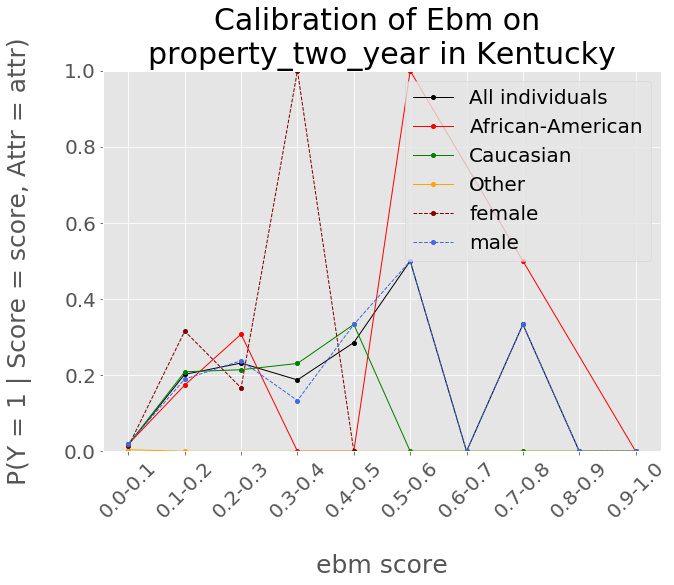

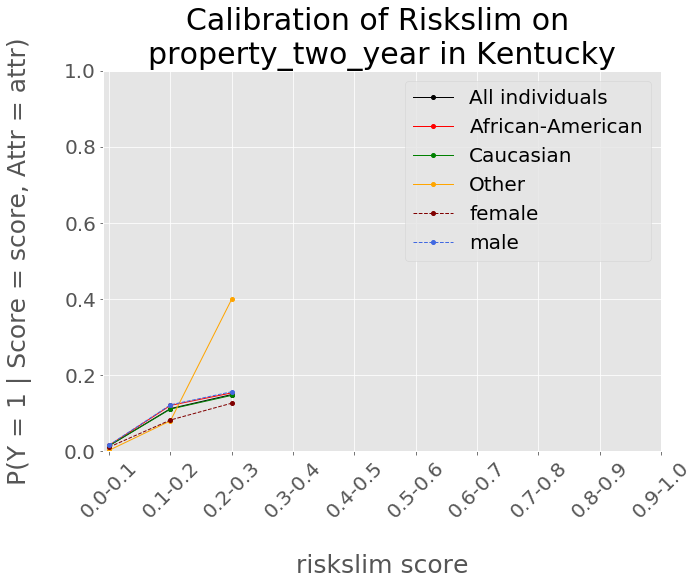

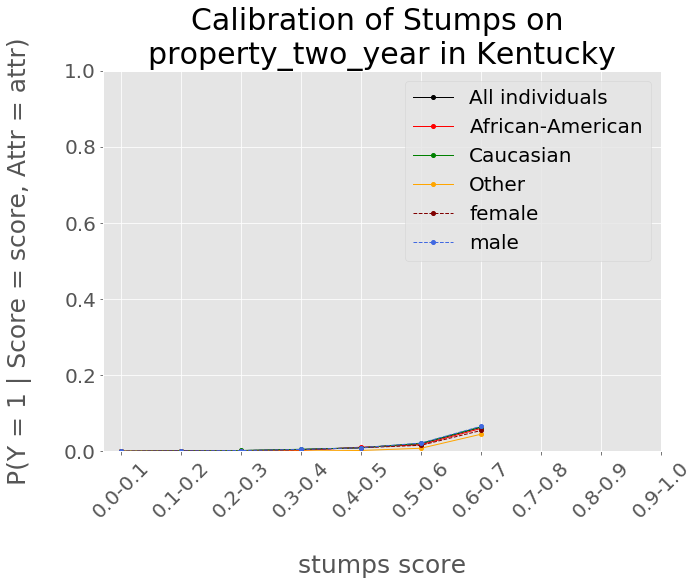

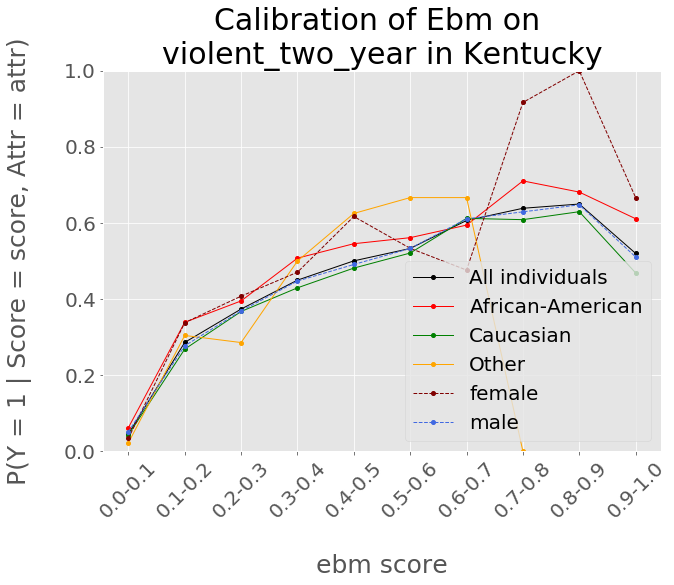

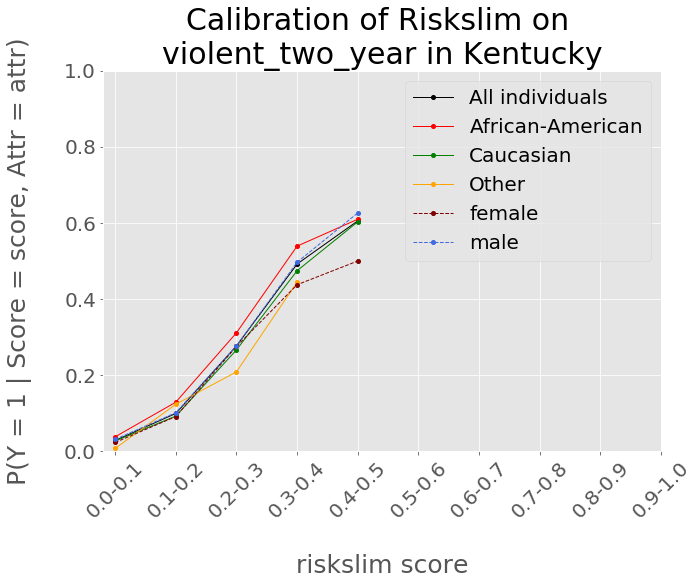

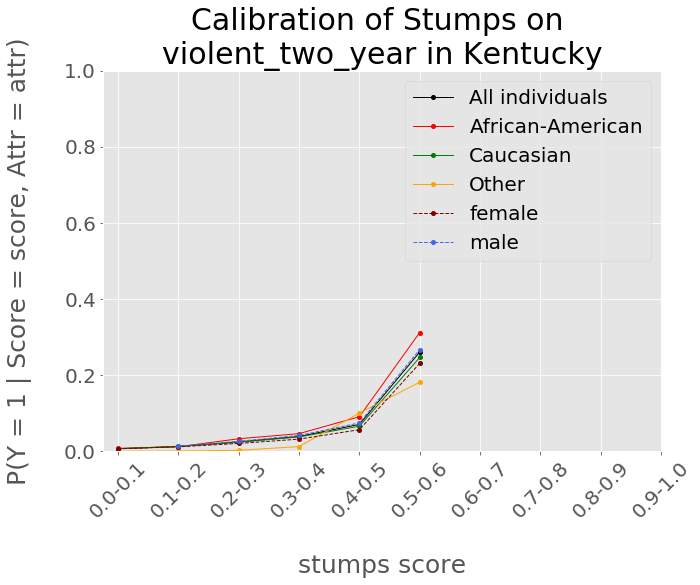

In [7]:
for name, calib_summary in calibration_data.items():
    recid_type, time_period, score_name = name.split("-")
    problem_name = "_".join([recid_type, time_period])

    calib, calib_grps = parse_calibration_matrix(calibration_matrix=calib_summary, 
                                                 problem_name=problem_name, 
                                                 score_name=score_name)
    
    plot_calibration_for_score_on_problem(calib=calib,
                                          calib_grps=calib_grps,
                                          problem_name=problem_name,
                                          score_name=score_name,
                                          region="Kentucky",
                                          xtick_labels=['0.0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5','0.5-0.6', 
                                                        '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0'],
                                          rotate_xticks=True,
                                          save_path="kentucky/logs/fairness_results/calibration_visualizations/" 
                                                      + score_name + "/" 
                                                      + score_name + "_" + problem_name + ".pdf")